# Problem Set # 3

### MACS 30100, Dr. Evans
### Zunda Xu ( zunda@uchicago.edu )

First, we import the packages used in this assignment and load the two dataset for two problems

In [1]:
# Import packages and load the data
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

# load the data
income = np.loadtxt('incomes.txt')
sick = pd.read_csv("sick.txt")

### Problem 1 : Some income data,  lognormal distribution and GMM

We will first define several functions used in this problem, including lognorm_pdf, data_moments, model_moments, err_vec and criterion function.

In [2]:
# Define function that generates values of a lognormal
# probability density function (PDF)
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and
    standard deviation sigma. Note that in this function, the values
    of x must be nonnegative and also the sigma must be strictly postive
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the lognormally distributed random
             variable
    mu     = scalar, mean of the lognormally distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals = (N,) vector, lognormal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''          
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi)) * 
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

In [3]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the lognormal distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormal distributed
             random variable
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    var_model  = scalar > 0, variance of test scores from model    
    std_model  = scalar > 0, standard deviation of test scores from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    # Since using the integral of the pdf of lognormal distribution may result 
    # inaccuracy and offhead, I use the analytic format of the model's mean and
    # variance directly
    
    mean_model = np.exp(mu + sigma ** 2/2)
    var_model = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma**2)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable

    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    

    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

#### Part ( a ) : Plot a histogram 

<IPython.core.display.Javascript object>


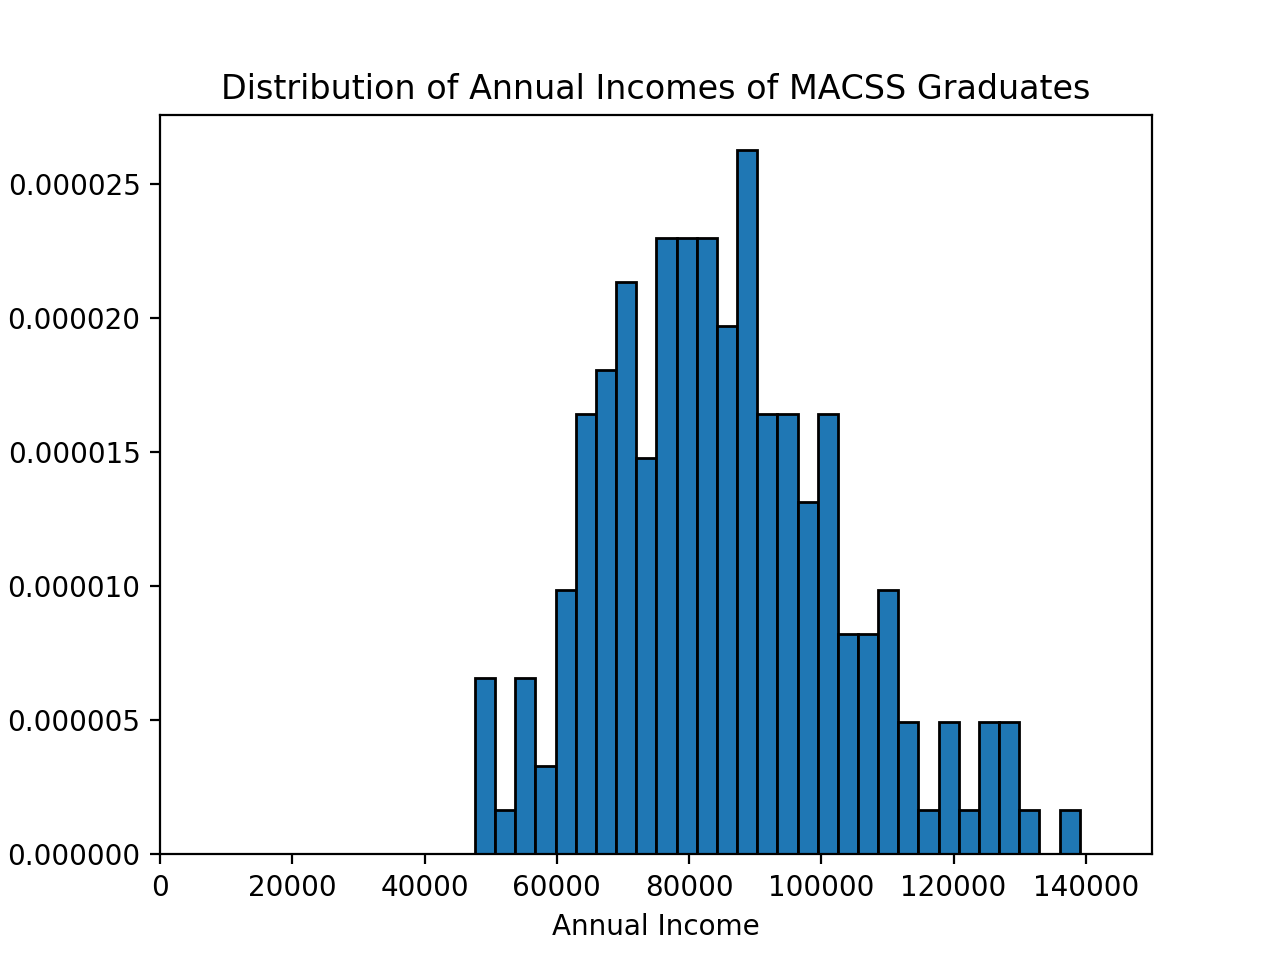

(0, 150000)

In [4]:
dist_income = np.linspace(0, 150000, 1000)
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Distribution of Annual Incomes of MACSS Graduates')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.xlim([0,150000]) # Plot the histogram of the data

#### Part ( b ) : Estimate the parameters  by GMM method

First of all, we use the GMM method to estimate the parameters mu and sigma, and the results are as follows:

In [5]:
mu_init = 11 # set the initial value of mu the same as problem set 2
sig_init = 0.5 # set the initial value of sigma the same as problem set 2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3318807729  sig_GMM1= 0.208696666481


Now, we will plot the estimated lognormal pdf against the histogram from part (a).

<IPython.core.display.Javascript object>


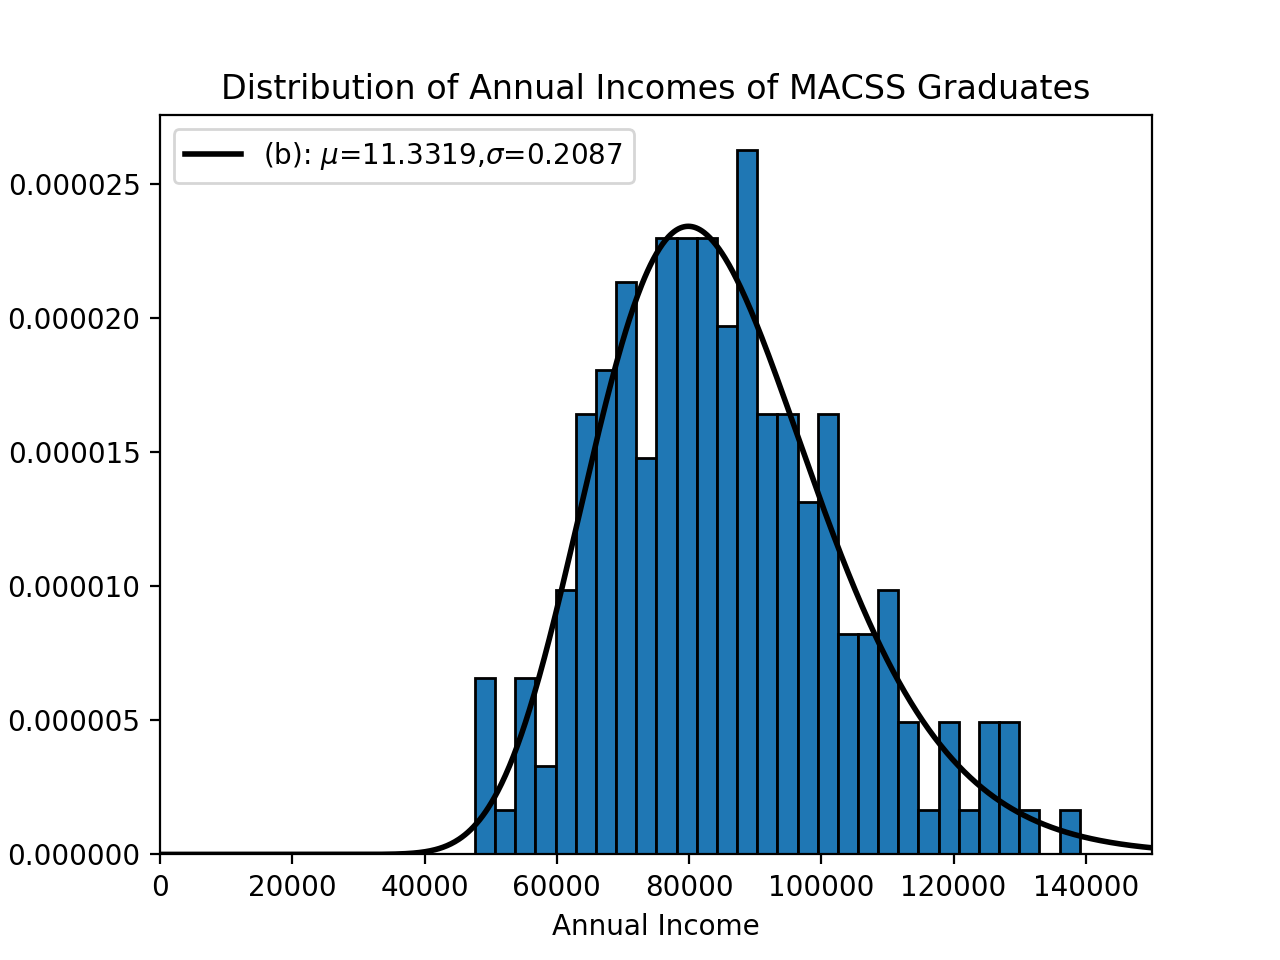

/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


In [6]:
dist_income = np.linspace(0, 150000, 1000)
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Distribution of Annual Incomes of MACSS Graduates')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.xlim([0,150000]) # Plot the histogram of the data

# Plot the GMM estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='(b): $\mu$=11.3319,$\sigma$=0.2087')
plt.legend(loc='upper left')

In [7]:
print('The value of GMM criterion function:', results.fun)
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(income, mu_GMM1, sig_GMM1, False).reshape(2,)
print()
print('The two data moments are as follows:')
print('Mean of data =', mean_data, ', Standard deviation of data =', std_data)
print()
print('The two model moments are as follows:')
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print()
print('Error vector=', err1)


The value of GMM criterion function: [[  6.99496828e-15]]

The two data moments are as follows:
Mean of data = 85276.8236063 , Standard deviation of data = 17992.542128

The two model moments are as follows:
Mean of model = 85276.8176502 , Standard deviation of model = 17992.5413002

Error vector= [ -6.98440504e-08  -4.60084439e-08]


#### Part ( c ) : Perform the two-step GMM estimator

First, we need calculate the variance covariance matrix and the optimal weighting matrix.

In [8]:
err2 = err_vec(income, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err2, err2.T) / income.shape[0]
print('The variance covariance matrix is:')
print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print()
print('The optimal weighting matrix is:')
print(W_hat2)

The variance covariance matrix is:
[[  2.43909569e-17   1.60670804e-17]
 [  1.60670804e-17   1.05838845e-17]]

The optimal weighting matrix is:
[[  1.99396408e+16   1.31348603e+16]
 [  1.31348603e+16   8.65234018e+15]]


Now, we will start our two-step GMM estimation, and the results of the estimation are as follows:

In [9]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1, sig_GMM1])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (income, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.3318808111  sig_GMM2= 0.208696676794


Then, we will plot this time's estimated lognormal pdf against the histogram from part (a) and the estimated lognormal pdf from part (b).

<IPython.core.display.Javascript object>


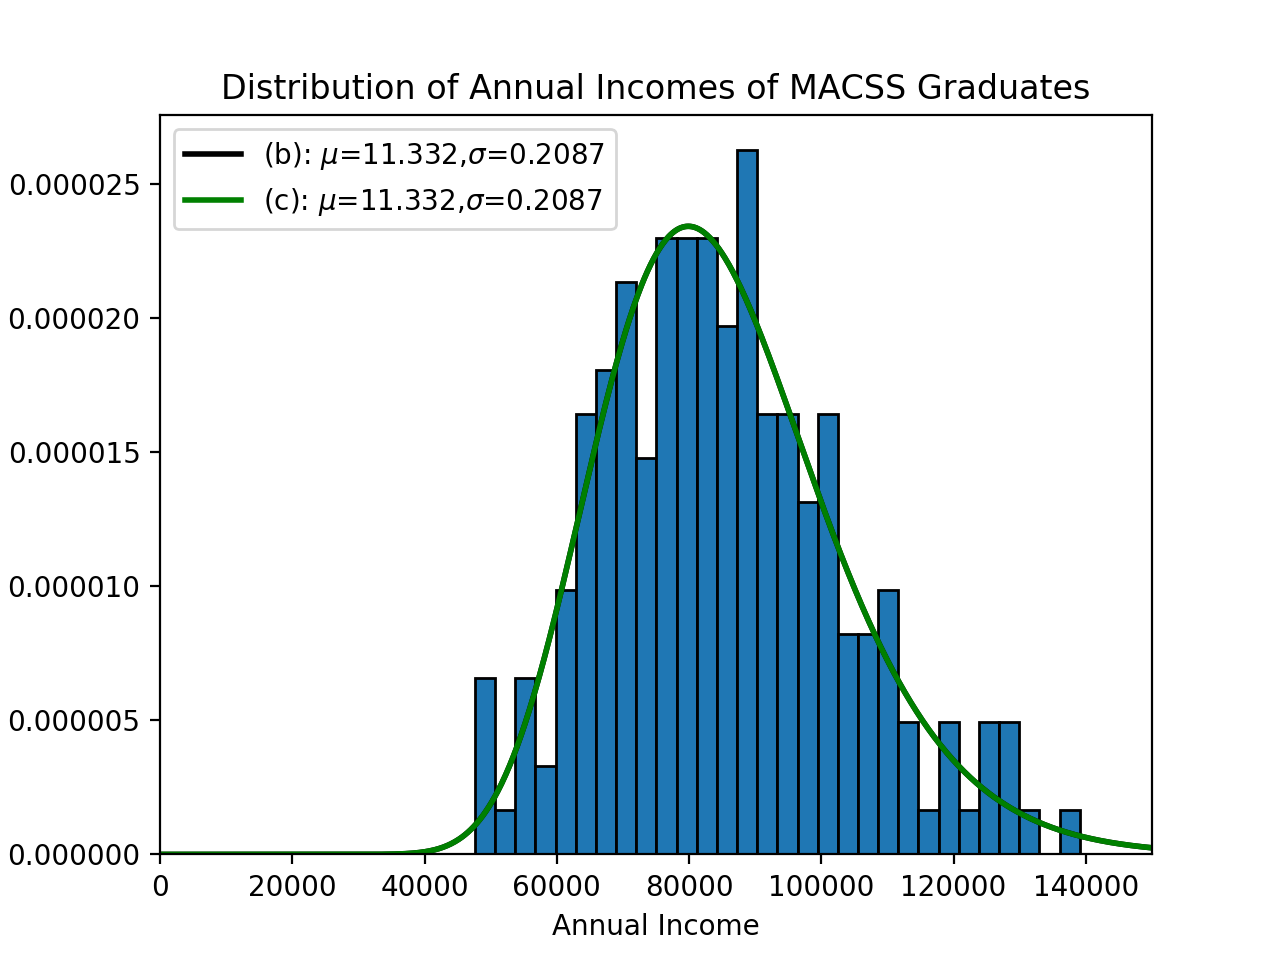

/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


In [10]:
dist_income = np.linspace(0, 150000, 1000)
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Distribution of Annual Incomes of MACSS Graduates')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.xlim([0,150000]) # Plot the histogram of the data

# Plot the GMM estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='(b): $\mu$=11.332,$\sigma$=0.2087')
plt.legend(loc='upper left')

# Plot the GMM2 estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM2, sig_GMM2),
         linewidth=2, color='g', label='(c): $\mu$=11.332,$\sigma$=0.2087')
plt.legend(loc='upper left')

In [11]:
print('The value of GMM criterion function:', results2.fun)
mean_data, std_data = data_moments(income)
mean_model_2, std_model_2 = model_moments(mu_GMM2, sig_GMM2)
err3 = err_vec(income, mu_GMM2, sig_GMM2, False).reshape(2,)
print()
print('The two data moments are as follows:')
print('Mean of data =', mean_data, ', Standard deviation of data =', std_data)
print()
print('The two model moments are as follows:')
print('Mean of model =', mean_model_2, ', Standard deviation of model =', std_model_2)
print()
print('Error vector=', err3)

The value of GMM criterion function: [[  2.53627630e-05]]

The two data moments are as follows:
Mean of data = 85276.8236063 , Standard deviation of data = 17992.542128

The two model moments are as follows:
Mean of model = 85276.8210871 , Standard deviation of model = 17992.5429339

Error vector= [ -2.95405833e-08   4.47905394e-08]


#### Part ( d ) :  Estimate the lognormal PDF to fit the data by GMM using different moments

First, we will redefine some functions used in this part, including data_moments, model_moments, err_vec and criterion functions.

In [12]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100000 <= x 


    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    bpct_3_dat = xvals[xvals >=100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable

    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        sts.norm.cdf

    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3

    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''

    bpct_1_mod = sts.norm.cdf(np.log(75000), loc = mu, scale = sigma)
    bpct_2_mod = sts.norm.cdf(np.log(100000), loc = mu, scale = sigma) - bpct_1_mod
    bpct_3_mod = 1 - sts.norm.cdf(np.log(100000), loc = mu, scale = sigma)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments3()
        model_moments3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of three moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


Now, we can start our GMM estimation by using three moments, and the results are as follows:

In [13]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
# W_hat[1, 1] = 2.0
# W_hat[2, 2] = 2.0
gmm_args = (income, W_hat)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

mu_GMM1_3= 11.3356813274  sig_GMM1_3= 0.210598453721


Next, we will plot the estimated lognormal pdf against the histogram from part (a).

<IPython.core.display.Javascript object>


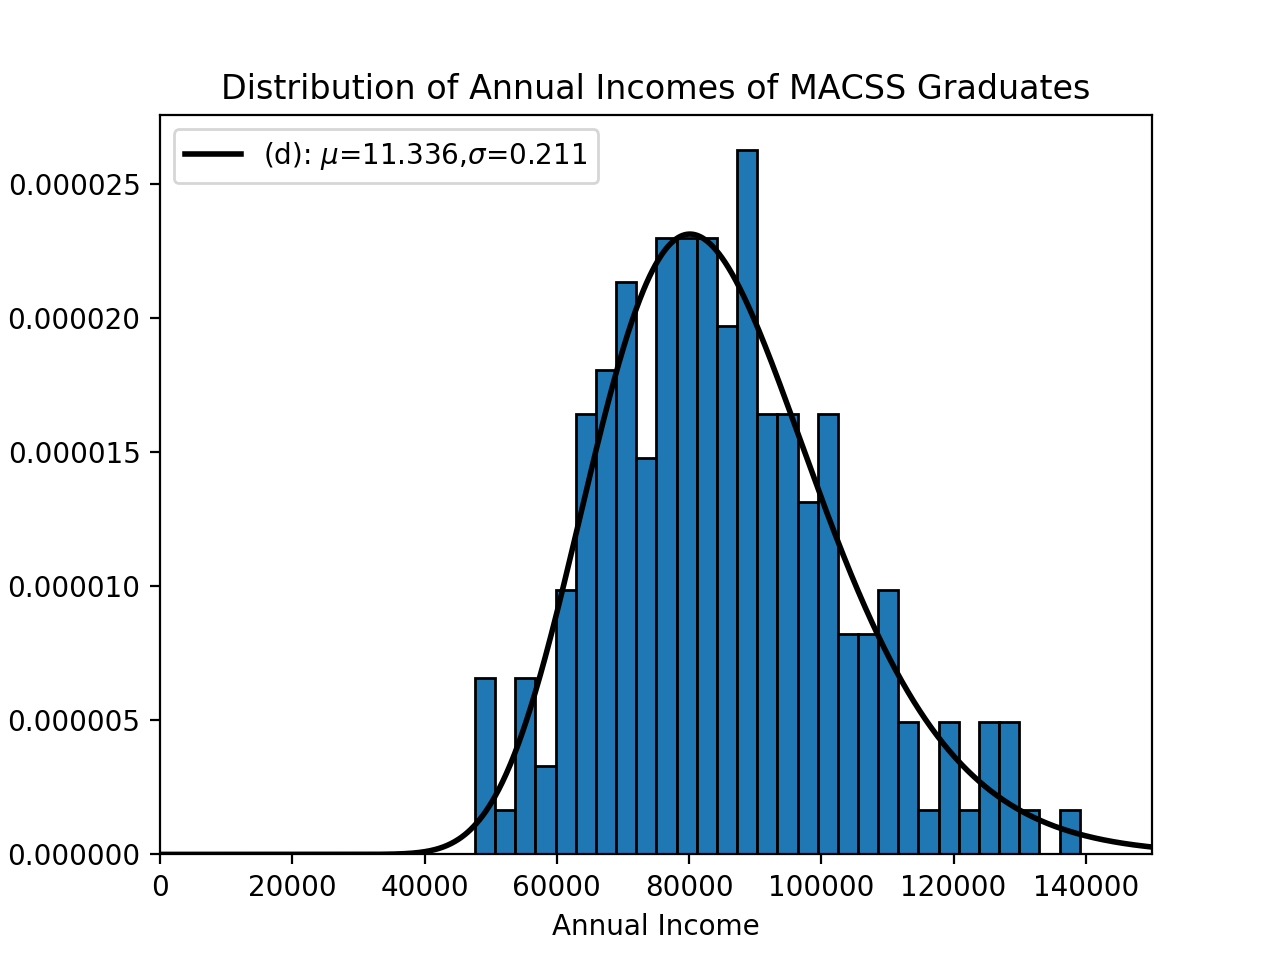

/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


In [14]:
dist_income = np.linspace(0, 150000, 1000)
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Distribution of Annual Incomes of MACSS Graduates')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.xlim([0,150000]) # Plot the histogram of the data

# Plot the GMM estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='k', label='(d): $\mu$=11.336,$\sigma$=0.211')
plt.legend(loc='upper left')


In [15]:
print('The value of GMM criterion function:', results_3.fun)
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(income)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM1_3, sig_GMM1_3)
err_3 = err_vec(income, mu_GMM1_3, sig_GMM1_3, False).reshape(2,)
print()
print('Three data moments are:',bpct_1_dat, bpct_2_dat, bpct_3_dat)
print()
print('Three model moments are:',bpct_1_mod, bpct_2_mod, bpct_3_mod)
print()
print('Error vector=', err_3)

The value of GMM criterion function: [[  2.53378840e-11]]

Three data moments are: 0.3 0.5 0.2

Three model moments are: 0.300000003633 0.500000005854 0.199999990513

Error vector= [ 0.00420802  0.01356259]


#### Part ( e ) : Perform the two-step GMM estimator by using the estimates from part ( d )

First, we need calculate the variance covariance matrix and the optimal weighting matrix.

In [16]:
err1_3= err_vec3(income, mu_GMM1_3, sig_GMM1_3, False)
VCV2_3 = np.dot(err1_3, err1_3.T) / income.shape[0]
print('The variance covariance matrix is:')
print(VCV2_3)
print()
W_hat2_3 = lin.pinv(VCV2_3)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print('The optimal weighting matrix is:')
print(W_hat2_3)

The variance covariance matrix is:
[[  7.33126041e-15   7.08892667e-15  -2.87192073e-14]
 [  7.08892667e-15   6.85460324e-15  -2.77698981e-14]
 [ -2.87192073e-14  -2.77698981e-14   1.12503556e-13]]

The optimal weighting matrix is:
[[  4.56770398e+11   4.41671920e+11  -1.78933540e+12]
 [  4.41671920e+11   4.27072520e+11  -1.73018918e+12]
 [ -1.78933540e+12  -1.73018918e+12   7.00947604e+12]]


Then, we could start our two-step GMM estimation, and the results are as follows:

In [17]:
#mu_init = 11
#sig_init = 0.5
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (income, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)


mu_GMM2_3= 11.3356813287  sig_GMM2_3= 0.210598456207


Next, we will plot this time's estimated lognormal pdf against the histogram from part (a) and the estimated lognormal pdf from part (d).

<IPython.core.display.Javascript object>


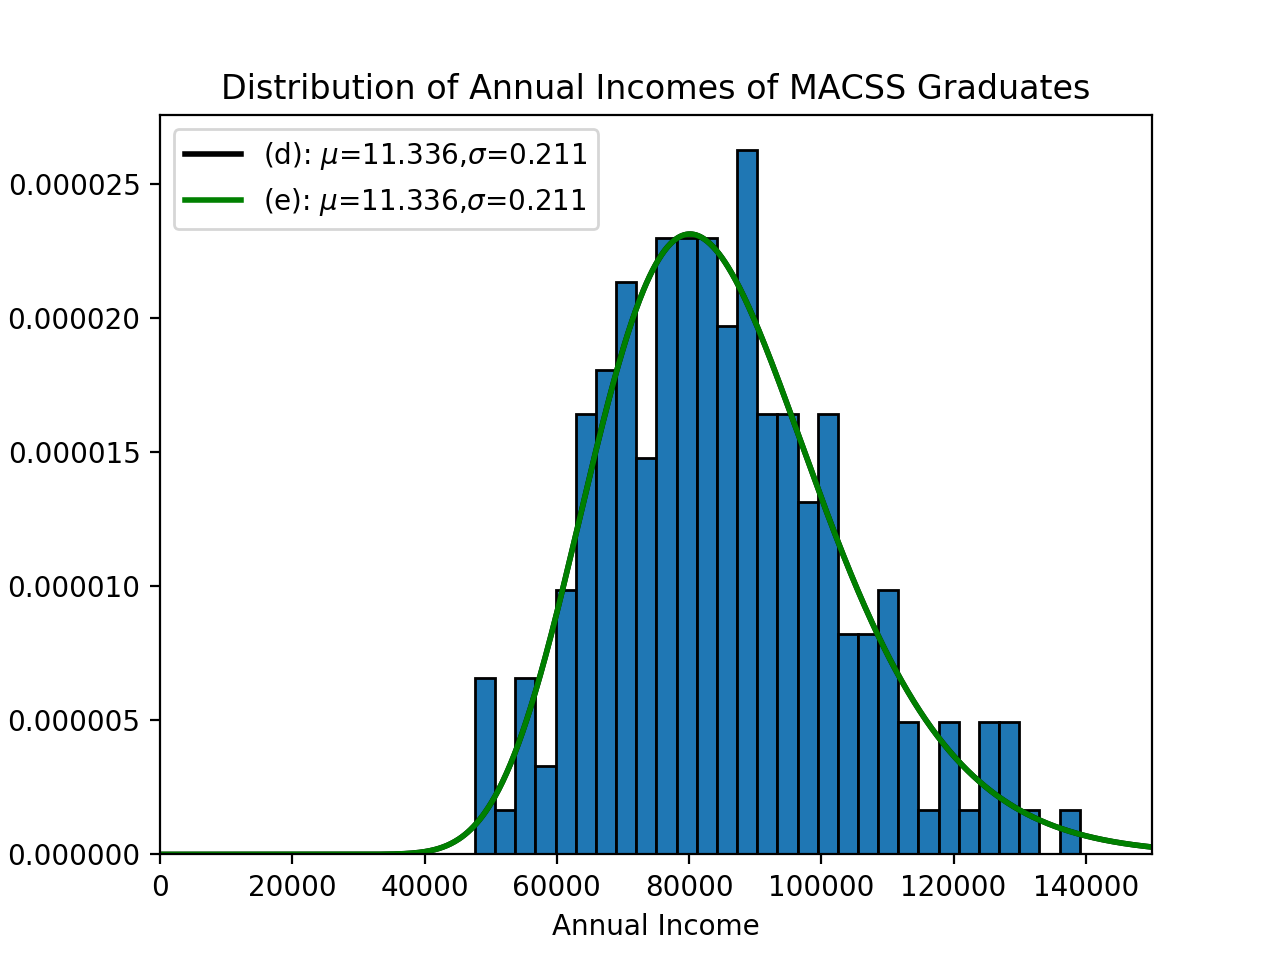

/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/winston/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


In [18]:
dist_income = np.linspace(0, 150000, 1000)
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Distribution of Annual Incomes of MACSS Graduates')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.xlim([0,150000]) # Plot the histogram of the data

# Plot the GMM estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='k', label='(d): $\mu$=11.336,$\sigma$=0.211')
plt.legend(loc='upper left')

plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM2_3, sig_GMM2_3),
         linewidth=2, color='g', label='(e): $\mu$=11.336,$\sigma$=0.211')
plt.legend(loc='upper left')

In [19]:
print('The value of GMM criterion function:', results2_3.fun)
bpct_1_dat2, bpct_2_dat2, bpct_3_dat2 = data_moments3(income)
bpct_1_mod2, bpct_2_mod2, bpct_3_mod2 = model_moments3(mu_GMM2_3, sig_GMM2_3)
err_3_2 = err_vec(income, mu_GMM2_3, sig_GMM2_3, False).reshape(2,)
print()
print('Three data moments are:',bpct_1_dat2, bpct_2_dat2, bpct_3_dat2)
print()
print('Three model moments are:',bpct_1_mod2, bpct_2_mod2, bpct_3_mod2)
print()
print('Error vector=', err_3_2)

The value of GMM criterion function: [[ 59.70708429]]

Three data moments are: 0.3 0.5 0.2

Three model moments are: 0.300000003753 0.500000001315 0.199999994931

Error vector= [ 0.00420802  0.01356261]


#### Part ( f ) : Which of the four estimations fits the data best

Answer:

As a matter of fact, observing the four estimated values of mu and sigma, there is only trivial difference between them. The estimation in part (b) and (c) are using the same model moments but different estimator (identity matrix and two-step), thus those two results are almost the same. Simiarly, the two estimations of part (d) and (e) are also almost the same, but compared with the two model moments, which use the mean and standard deviation of the lognormal directly, there is still some trivial difference. From my point of view, I think the estimation in part (c) fits the data best, since the two model moments used in this question can be represented directly by mu and sigma, while as to the three model moments used in part (d),(e), we still need to calculate the CDF of the distribution to get the model moments, which will increase the error and decrease the accuracy. Meanwhile, using the two-step estimator is also more precise than the identity matrix.

### Problem 2 : Linear Regression and GMM

#### Part ( a ) :  Estimate the parameters of the model by GMM

In [20]:
# Data processing
xvals = sick.iloc[:, 1:].values # values of vector X in the linear regression model
yvals = sick.loc[:, "sick"].values # values of dependent variable in the model
xvals = np.concatenate((np.ones((len(yvals), 1)),xvals), axis = 1) # Add 1 to the front of each data, 
                                                                          #which is correspond with parameter Beta_0
num_param = xvals.shape[1]
# the number of total parameters in the model

In [21]:
# Data moments are the values of sick_i, which is just the value of y
data_moments = yvals.reshape(len(yvals),1)

In [22]:
# Define the criterion function
def criterion4(params, *args):
    beta = params[0:num_param]
    xvals, W = args
    err = xvals @ beta - yvals
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

# Estimate the value of parameters in the model
W_hat_5 = np.eye(len(yvals))
gmm_args = (xvals, W_hat_5)
results5 = opt.minimize(criterion4, [1,0,0,0], args=(gmm_args), method='L-BFGS-B', bounds = ((None, None), 
                            (None, None),(None, None),(None, None)))

In [23]:
beta0, beta1, beta2, beta3 = results5.x
print('The estimated parameter beta_0 of the model is:', beta0)
print('The estimated parameter beta_1 of the model is:', beta1)
print('The estimated parameter beta_2 of the model is:', beta2)
print('The estimated parameter beta_3 of the model is:', beta3)
print()
print('The value of GMM criterion function is:', results5.fun)


The estimated parameter beta_0 of the model is: 0.251644863633
The estimated parameter beta_1 of the model is: 0.0129334709663
The estimated parameter beta_2 of the model is: 0.400500984705
The estimated parameter beta_3 of the model is: -0.00999170971145

The value of GMM criterion function is: 0.00182128980608
